In [13]:
from decode import get_depth_maps

import glob
import pylab as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Retrieve depth maps

In this notebook, we will explore basic localization from image depth maps. Depth maps are compressed to reduce the consumed (as .gz files) harddisk space, hence, all depth maps have to be decoded. Each file contains approx. 1800 depth maps, i.e. one minute of data at 30 FPS. In this notebook, we will retrieve 5 depth map files. The result is dictionary, hashing 9004 depth maps (in numpy array format with a resolution of (850, 700) pixels) with their associated timestamp (i.e. the time at which each depth map has been recorded). For convenience, we also save the depth maps and time in variables `depth_maps` and `time` seperately.

In [8]:
from sociophysicsDataHandler import SociophysicsDataHandler

# initialize the data handler, load credentials
dh = SociophysicsDataHandler()
dh.load_credentials(auth_fname="auth.txt")

# fetch depth map data
dh.fetch_depth_data_from_path(path = 'depth_kinect_glow17/17.11.11-15-53-28_2017-11-11_20-25-41.262248_9d6c8ecc-8253-4578-9714-1691ba5596cd_00000264_475993.tar.json.gz')

# for convenience, save the data in variables
depth_maps = dh.dd
time = dh.t

trying to fetch: /ProRail_USE_LL_data/depth_kinect_glow17/17.11.11-15-53-28_2017-11-11_20-25-41.262248_9d6c8ecc-8253-4578-9714-1691ba5596cd_00000264_475993.tar.json.gz
1804 depth maps retrieved!
Date: 2017-11-11
Between 20:25:41.262248 and 20:26:43.436257

depth data fetched. Accessible as <this-object>.dd and associated timestamps accesible as <this-object>.t


## Plot some of the depth maps

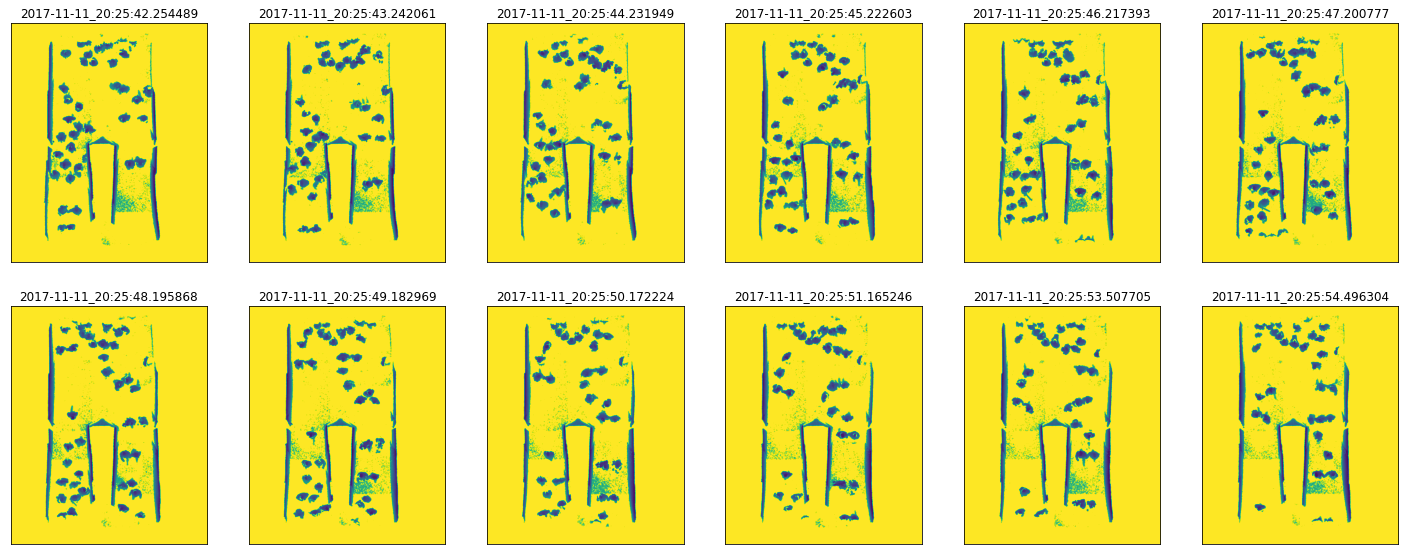

In [9]:
fig, axes = plt.subplots(nrows=2, ncols = 6, figsize=(20, 8))
fig.tight_layout()
frame= 0
for row in axes:
    for ax in row:
        
        frame += 30 # one second later since we have 30 FPS data
        
        # plot depth map
        ax.imshow(depth_maps[frame])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(time[frame])

## Make video

In many cases, making a video from the depth maps is useful. For instance, when we want to check if the trajectory data that follows from a localization algorithm is accurate and genuine. In other cases, the trajectory data that regards pedestrians as point particles might not be informative enough (e.g. when we are interested in shoulder orientation) or clear enough (e.g. when we want to see the time evolution of a trajectory as opposed to plotting the full trajectory at once). 

In [12]:
from matplotlib import animation
from IPython.display import HTML

N_start = 0 #start video from the 0th depth map
N_end = 500 #end video at the 500th depth map
skip = 1 #enables skipping frames to reduce render time

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(8,10))
fig.tight_layout()

ims = []
# iterate over all frames
for i in np.arange(N_start, N_end)[::skip]:
    
    plt.xticks([]);     plt.yticks([])
    im = plt.imshow(depth_maps[i], animated=True)                  #plot depth map
    timestamp =  plt.text(50, 50, time[i], animated=True)   #plot timestamp 
    ims.append([im, timestamp])

# render animation
ani = animation.ArtistAnimation(fig, ims, interval=33*skip, blit=True)

plt.close("all")

# show animation
HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

## Perform basic localization

The pedestrian detection algorithm is hereby concisely reported. The reader in need for more details is referred to https://www.sciencedirect.com/science/article/pii/S2352146514000490

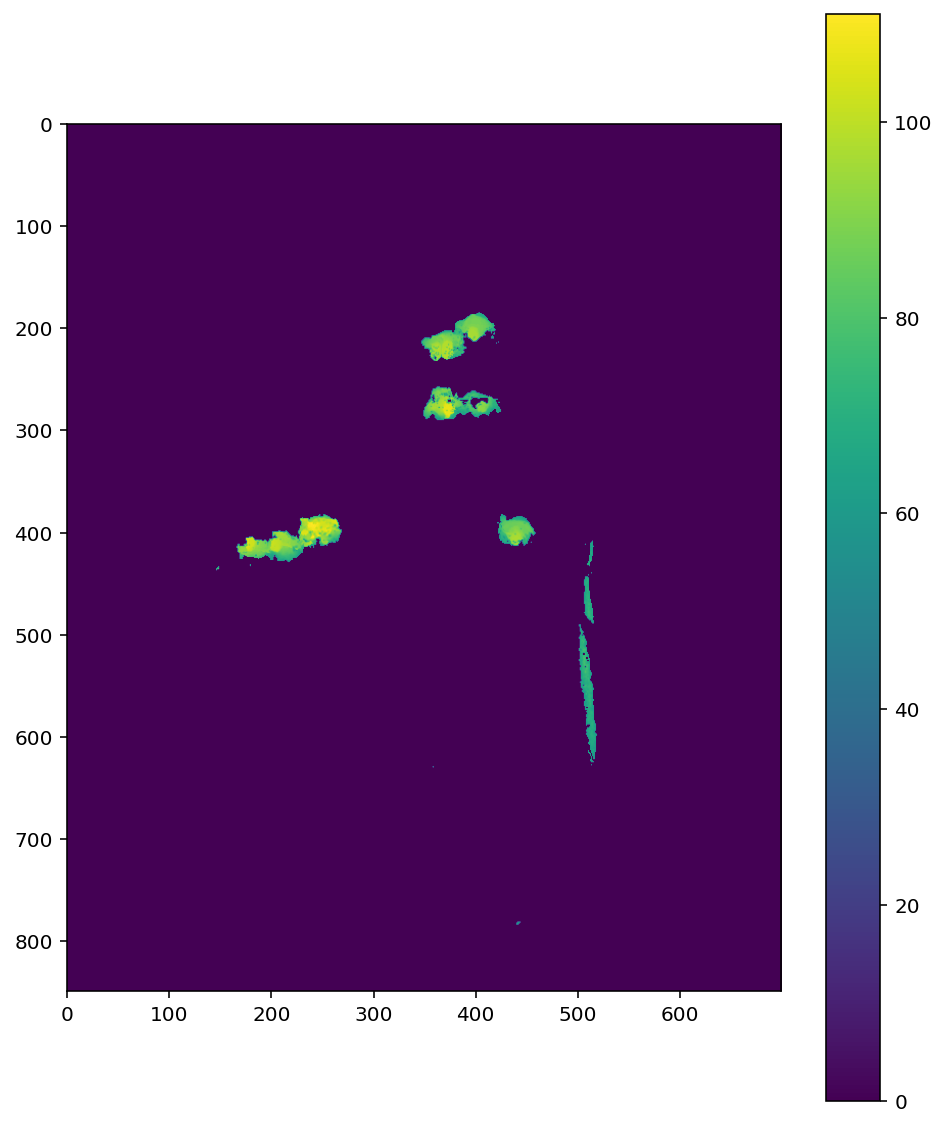

In [48]:
epsilon = 50
h = 60

# obtain background by averaging over first 500 depth maps
background = depth_maps[:500].mean(axis=0)

# remove background (may take some time..)
foreground = np.where(background  - depth_maps[:500] < epsilon, 0, mean_depth_map -  depth_maps[:500]).astype('uint8')

# the foreground is likely populated by elements which are not tall enough to 
# be pedestrians, therefore a second thresholding operation is performed.
foreground = np.where(foreground < h, 0, foreground)

# plot a depth map
plt.figure(0, figsize=(8,10))
plt.imshow(foreground[100])
plt.xlim([100, 500]); plt.ylim([100, 700])
plt.colorbar();

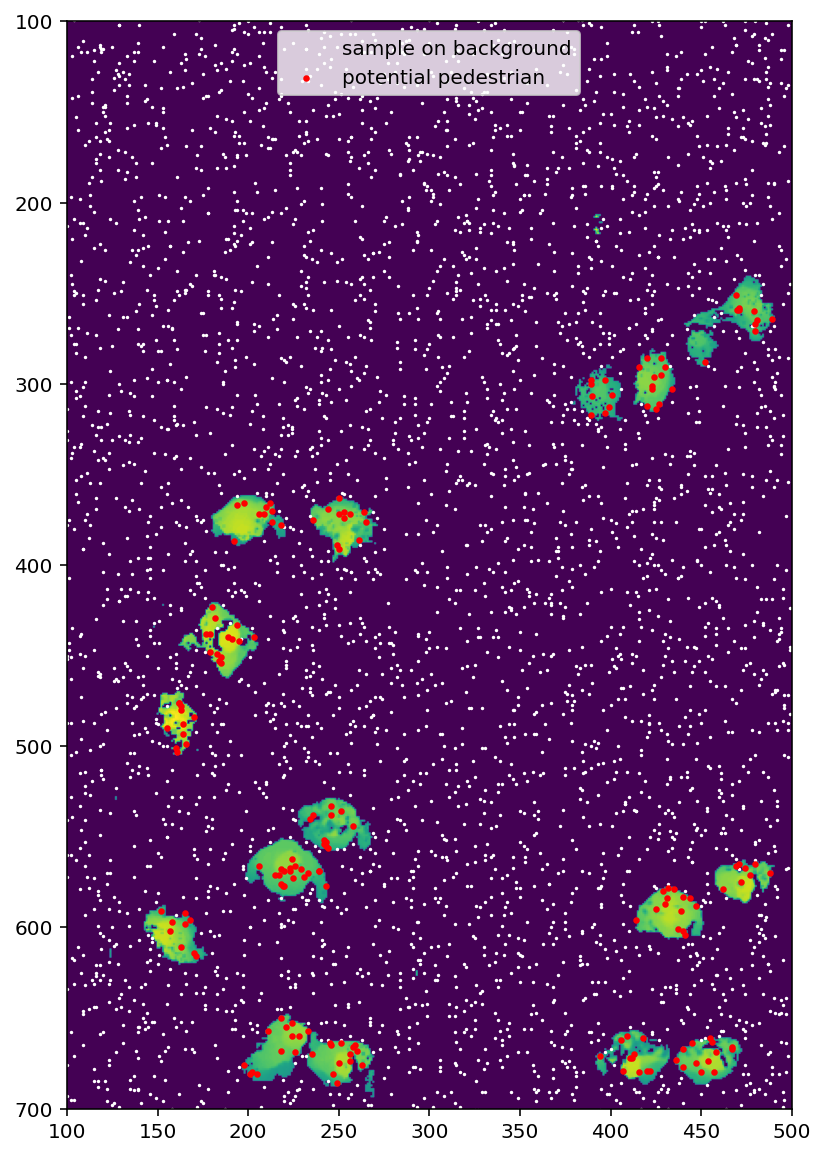

In [260]:
N = 5000

# let's do the analysis on a single depth map first..
single_depth_map = foreground[17]

# sample N random points on the depth map. We see that pedestrians are only present in a 
# small box with 100 < x < 500 and 50 < y < 800, thus we sample in this region
x = np.random.randint(low=100, high = 500, size=N)
y = np.random.randint(low=50, high = 800, size=N)

#extract the depth values at these sampled positions
z = single_depth_map[y,x]

# plot the samples
plt.figure(0, figsize=(8,10))
plt.imshow(single_depth_map)
plt.xlim([100, 500]); plt.ylim([700, 100])
plt.scatter(x, y, s=0.5, color='white', label='sample on background')

x_no_background = x[z > 60]
y_no_background = y[z > 60]

plt.scatter(x_no_background, y_no_background, s=5, color='red', label='potential pedestrian')

plt.legend()




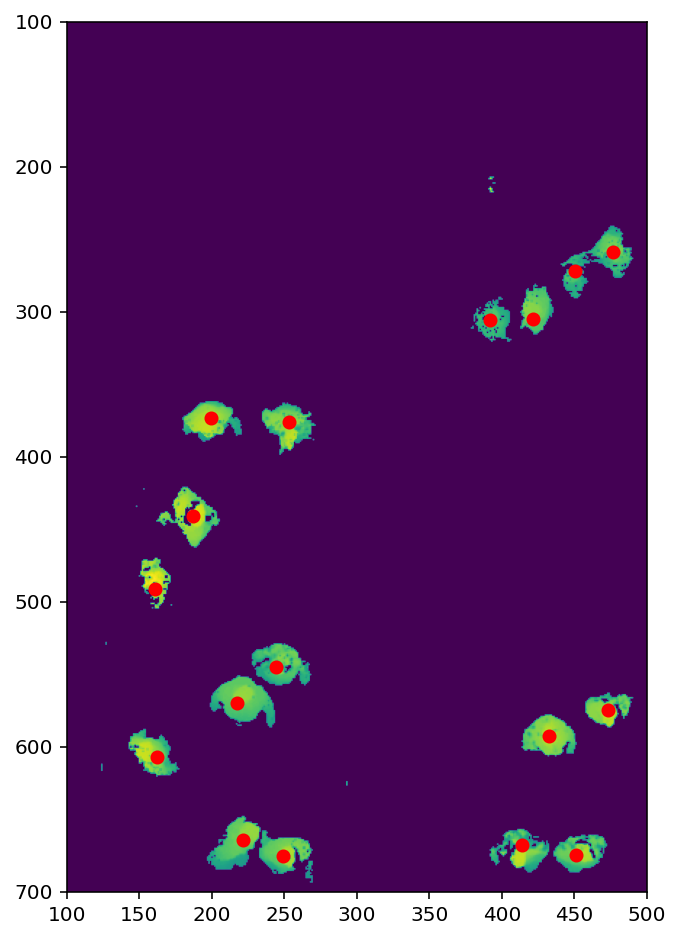

In [258]:
from scipy.cluster.hierarchy import fclusterdata

max_d = 60 #scale size of the human body

sampled_points = np.vstack([x_no_background, y_no_background]).T
clusters = fclusterdata(sampled_points, max_d, criterion='distance', method='ward')

unique_clusters = np.unique(clusters)

positions = []

for i in unique_clusters:
    pedestrian_position = sampled_points[clusters == i].mean(axis=0)
    positions.append(pedestrian_position)
    
positions = np.array(positions)

plt.figure(figsize=(10, 8))
plt.imshow(single_depth_map)
plt.xlim([100, 500]); plt.ylim([700, 100])
plt.scatter(positions[:,0], positions[:,1], color='red')  # plot points with cluster dependent colors
plt.show()